In [1]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

# Tutorial - Assemble the data on the pets dataset

> Using `Datasets`, `Pipeline`, `TfmdLists` and `Transform` in computer vision

## Overview

In this tutorial, we look in depth at the middle level API for collecting data in computer vision. First we will see how to use:

- `Transform` to process the data
- `Pipeline` to composes transforms

Those are just functions with added functionality. For dataset processing, we will look in a second part at 

- `TfmdLists` to apply one `Pipeline` of `Tranform`s on a collection of items
- `Datasets` to apply several `Pipeline` of `Transform`s on a collection of items in parallel and produce tuples

The general rule is to use `TfmdLists` when your transforms will output the tuple (input,target) and `Datasets` when you build separate `Pipeline`s for each of your input(s)/target(s).

After this tutorial, you might be interested by the [siamese tutorial](http://docs.fast.ai/tutorial.siamese) that goes even more in depth in the data APIs, showing you how to write your custom types and how to customize the behavior of `show_batch` and `show_results`.

In [2]:
from fastai.vision.all import *

## Processing data

Cleaning and processing data is one of the most time-consuming things in machine learning, which is why fastai tries to help you as much as it can. At its core, preparing the data for your model can be formalized as a sequence of transformations you apply to some raw items. For instance, in a classic image classification problem, we start with filenames. We have to open the corresponding images, resize them, convert them to tensors, maybe apply some kind of data augmentation, before we are ready to batch them. And that's just for the inputs of our model, for the targets, we need to extract the label of our filename and convert it to an integer.

This process needs to be somewhat reversible, because we often want to inspect our data to double check what we feed the model actually makes sense. That's why fastai represents all those operations by `Transform`s, which you can sometimes undo with a `decode` method.

### Transform

First we'll have a look at the basic steps using a single MNIST image. We'll start with a filename, and see step by step how it can be converted in to a labelled image that can be displayed and used for modeling. We use the usual `untar_data` to download our dataset (if necessary) and get all the image files:

In [3]:
source = untar_data(URLs.MNIST_TINY)/'train'
items = get_image_files(source)
fn = items[0]; fn

Path('/home/yarnapp/.fastai/data/mnist_tiny/train/7/8511.png')

We'll look at each `Transform` needed in turn. Here's how we can open an image file:

In [4]:
img = PILImage.create(fn); img

Then we can convert it to a `C*H*W` tensor (for channel x height x width, which is the convention in PyTorch):

In [5]:
tconv = ToTensor()
img = tconv(img)
img.shape,type(img)

(torch.Size([3, 28, 28]), fastai.torch_core.TensorImage)

Now that's done, we can create our labels. First extracting the text label:

In [6]:
lbl = parent_label(fn); lbl

'7'

And then converting to an int for modeling:

In [7]:
tcat = Categorize(vocab=['3','7'])
lbl = tcat(lbl); lbl

TensorCategory(1)

We use `decode` to reverse transforms for display. Reversing the `Categorize` transform result in a class name we can display:

In [8]:
lbld = tcat.decode(lbl)
lbld

'7'

### Pipeline

We can compose our image steps using `Pipeline`:

In [9]:
pipe = Pipeline([PILImage.create,tconv])
img = pipe(fn)
img.shape

torch.Size([3, 28, 28])

A `Pipeline` can decode and show an item.

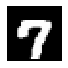

In [10]:
pipe.show(img, figsize=(1,1), cmap='Greys');

The show method works behind the scenes with types. Transforms will make sure the type of an element they receive is preserved. Here `PILImage.create` returns a `PILImage`, which knows how to show itself. `tconv` converts it to a `TensorImage`, which also knows how to show itself.

In [11]:
type(img)

fastai.torch_core.TensorImage

Those types are also used to enable different behaviors depending on the input received (for instance you don't do data augmentation the same way on an image, a segmentation mask or a bounding box).

## Loading the pets dataset using only `Transform`

Let's see how to use `fastai.data` to process the Pets dataset. If you are used to writing your own PyTorch `Dataset`s, what will feel more natural is to write everything in one `Transform`. We use *source* to refer to the underlying source of our data (e.g. a directory on disk, a database connection, a network connection, etc). Then we grab the items.

In [12]:
source = untar_data(URLs.PETS)/"images"
items = get_image_files(source)

We'll use this function to create consistently sized tensors from image files:

In [13]:
def resized_image(fn:Path, sz=128):
    x = Image.open(fn).convert('RGB').resize((sz,sz))
    # Convert image to tensor for modeling
    return tensor(array(x)).permute(2,0,1).float()/255.

Before we can create a `Transform`, we need a type that knows how to show itself (if we want to use the show method). Here we define a `TitledImage`:

In [14]:
class TitledImage(fastuple):
    def show(self, ctx=None, **kwargs): show_titled_image(self, ctx=ctx, **kwargs)

Let's check it works:

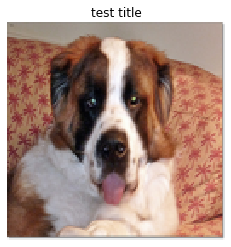

In [15]:
img = resized_image(items[0])
TitledImage(img,'test title').show()

### Using decodes for showing processed data

To decode data for showing purposes (like de-normalizing an image or converting back an index to its corresponding class), we implement a <code>decodes</code> method inside a `Transform`.

In [16]:
class PetTfm(Transform):
    def __init__(self, vocab, o2i, lblr): self.vocab,self.o2i,self.lblr = vocab,o2i,lblr
    def encodes(self, o): return [resized_image(o), self.o2i[self.lblr(o)]]
    def decodes(self, x): return TitledImage(x[0],self.vocab[x[1]])

The `Transform` opens and resizes the images on one side, label it and convert that label to an index using `o2i` on the other side. Inside the <code>decodes</code> method, we decode the index using the `vocab`. The image is left as is (we can't really show a filename!).

To use this `Transform`, we need a label function. Here we use a regex on the `name` attribute of our filenames:

In [17]:
labeller = using_attr(RegexLabeller(pat = r'^(.*)_\d+.jpg$'), 'name')

Then we gather all the possible labels, uniqueify them and ask for the two correspondences (vocab and o2i) using `bidir=True`. We can then use them to build our pet transform.

In [18]:
vals = list(map(labeller, items))
vocab,o2i = uniqueify(vals, sort=True, bidir=True)
pets = PetTfm(vocab,o2i,labeller)

We can check how it's applied to a filename:

In [19]:
x,y = pets(items[0])
x.shape,y

(torch.Size([3, 128, 128]), 30)

And we can decode our transformed version and show it:

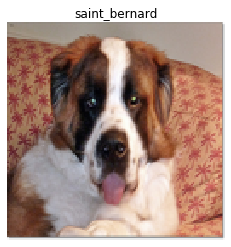

In [20]:
dec = pets.decode([x,y])
dec.show()

Note that like `__call__ ` and <code>encodes</code>, we implemented a <code>decodes</code> method but we actually call `decode` on our `Transform`.

Also note that our <code>decodes</code> method received the two objects (x and y). We said in the previous section `Transform` dispatch over tuples (for the encoding as well as the decoding) but here it took our two elements as a whole and did not try to decode x and y separately. Why is that? It's because we pass a list `[x,y]` to decodes. `Transform`s dispatch over tuples, but tuples only. And as we saw as well, to prevent a `Transform` from dispatching over a tuple, we just have to make it an `ItemTransform`:

In [21]:
class PetTfm(ItemTransform):
    def __init__(self, vocab, o2i, lblr): self.vocab,self.o2i,self.lblr = vocab,o2i,lblr
    def encodes(self, o): return (resized_image(o), self.o2i[self.lblr(o)])
    def decodes(self, x): return TitledImage(x[0],self.vocab[x[1]])

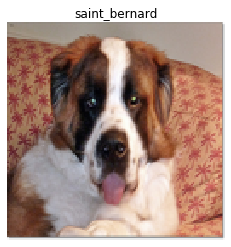

In [22]:
dec = pets.decode(pets(items[0]))
dec.show()

### Setting up the internal state with a setups

We can now let's make our `ItemTransform` automatically state its state form the data. This way, when we combine together our `Transform` with the data, it will automatically get setup without having to do anything. This is very easy to do: just copy the lines we had before to build the categories inside the transform in a <code>setups</code> method:

In [23]:
class PetTfm(ItemTransform):
    def setups(self, items):
        self.labeller = using_attr(RegexLabeller(pat = r'^(.*)_\d+.jpg$'), 'name')
        vals = map(self.labeller, items)
        self.vocab,self.o2i = uniqueify(vals, sort=True, bidir=True)

    def encodes(self, o): return (resized_image(o), self.o2i[self.labeller(o)])
    def decodes(self, x): return TitledImage(x[0],self.vocab[x[1]])

Now we can create our `Transform`, call its setup, and it will be ready to be used:

In [24]:
pets = PetTfm()
pets.setup(items)
x,y = pets(items[0])
x.shape, y

(torch.Size([3, 128, 128]), 30)

And like before, there is no problem to decode it:

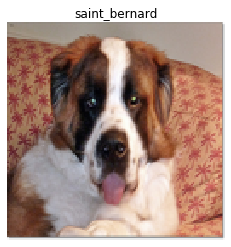

In [25]:
dec = pets.decode((x,y))
dec.show()

### Combining our `Transform` with data augmentation in a `Pipeline`.

We can take advantage of fastai's data augmentation transforms if we give the right type to our elements. Instead of returning a standard `PIL.Image`, if our transform returns the fastai type `PILImage`, we can then use any fastai's transform with it. Let's just return a `PILImage` for our first element:

In [26]:
class PetTfm(ItemTransform):
    def setups(self, items):
        self.labeller = using_attr(RegexLabeller(pat = r'^(.*)_\d+.jpg$'), 'name')
        vals = map(self.labeller, items)
        self.vocab,self.o2i = uniqueify(vals, sort=True, bidir=True)

    def encodes(self, o): return (PILImage.create(o), self.o2i[self.labeller(o)])
    def decodes(self, x): return TitledImage(x[0],self.vocab[x[1]])

We can then combine that transform with `ToTensor`, `Resize` or `FlipItem` to randomly flip our image in a `Pipeline`:

In [27]:
tfms = Pipeline([PetTfm(), Resize(224), FlipItem(p=1), ToTensor()])

Calling `setup` on a `Pipeline` will set each transform in order:

In [28]:
tfms.setup(items)

To check the setup was done properly, we want to see if we did build the vocab. One cool trick of `Pipeline` is that when asking for an attribute, it will look through each of its `Transform`s for that attribute and give you the result (or the list of results if the attribute is in multiple transforms):

In [29]:
tfms.vocab

(#37) ['Abyssinian','Bengal','Birman','Bombay','British_Shorthair','Egyptian_Mau','Maine_Coon','Persian','Ragdoll','Russian_Blue'...]

Then we can call our pipeline:

In [30]:
x,y = tfms(items[0])
x.shape,y

(torch.Size([3, 224, 224]), 30)

We can see `ToTensor` and `Resize` were applied to the first element of our tuple (which was of type `PILImage`) but not the second. We can even have a look at our element to check the flip was also applied:

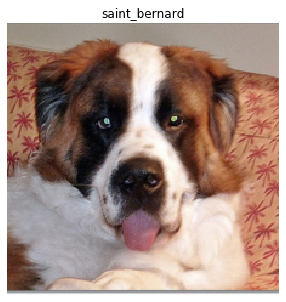

In [31]:
tfms.show(tfms(items[0]))

`Pipeline.show` will call decode on each `Transform` until it gets a type that knows how to show itself. The library considers a tuple as knowing how to show itself if all its parts have a `show` method. Here it does not happen before reaching `PetTfm` since the second part of our tuple is an int. But after decoding the original `PetTfm`, we get a `TitledImage` which has a `show` method.

It's a good point to note that the `Transform`s of the `Pipeline` are sorted by their internal `order` attribute (with a default of `order=0`). You can always check the order in which the transforms are in a `Pipeline` by looking at its representation:

In [32]:
tfms

Pipeline: PetTfm -> FlipItem -- {'p': 1} -> Resize -- {'size': (224, 224), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor

Even if we define `tfms` with `Resize` before `FlipItem`, we can see they have been reordered because we have:

In [33]:
FlipItem.order,Resize.order

(0, 1)

To customize the order of a `Transform`, just set `order = ...` before the `__init__` (it's a class attribute). Let's make `PetTfm` of order -5 to be sure it's always run first:

In [34]:
class PetTfm(ItemTransform):
    order = -5
    def setups(self, items):
        self.labeller = using_attr(RegexLabeller(pat = r'^(.*)_\d+.jpg$'), 'name')
        vals = map(self.labeller, items)
        self.vocab,self.o2i = uniqueify(vals, sort=True, bidir=True)

    def encodes(self, o): return (PILImage.create(o), self.o2i[self.labeller(o)])
    def decodes(self, x): return TitledImage(x[0],self.vocab[x[1]])

Then we can mess up the order of the transforms in our `Pipeline` but it will fix itself:

In [35]:
tfms = Pipeline([Resize(224), PetTfm(), FlipItem(p=1), ToTensor()])
tfms

Pipeline: PetTfm -> FlipItem -- {'p': 1} -> Resize -- {'size': (224, 224), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor

Now that we have a good `Pipeline` of transforms, let's add it to a list of filenames to build our dataset. A `Pipeline` combined with a collection is a `TfmdLists` in fastai.

## `TfmdLists` and `Datasets`

The main difference between `TfmdLists` and `Datasets` is the number of `Pipeline`s you have: `TfmdLists` take one `Pipeline` to transform a list (like we currently have) whereas `Datasets` combines several `Pipeline`s in parallel to create a tuple from one set of raw items, for instance a tuple (input, target).

### One pipeline makes a `TfmdLists`

Creating a `TfmdLists` just requires a list of items and a list of transforms that will be combined in a `Pipeline`:

In [36]:
tls = TfmdLists(items, [Resize(224), PetTfm(), FlipItem(p=0.5), ToTensor()])
x,y = tls[0]
x.shape,y

(torch.Size([3, 224, 224]), 30)

We did not need to pass anything to `PetTfm` thanks to our setup method: the `Pipeline` was automatically setup on the `items` during the initialization, so `PetTfm` has created its vocab like before:

In [37]:
tls.vocab

(#37) ['Abyssinian','Bengal','Birman','Bombay','British_Shorthair','Egyptian_Mau','Maine_Coon','Persian','Ragdoll','Russian_Blue'...]

We can ask the `TfmdLists` to show the items we got:

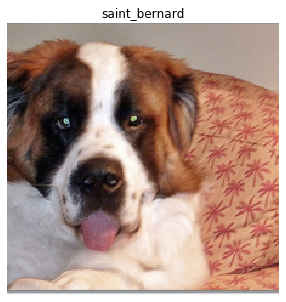

In [38]:
tls.show((x,y))

Or we have a shortcut with `show_at`:

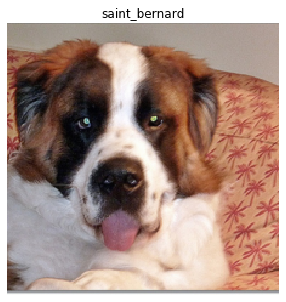

In [39]:
show_at(tls, 0)

### Traning and validation set

`TfmdLists` has an 's' in its name because it can represent several transformed lists: your training and validation sets. To use that functionality, we just need to pass `splits` to the initialization. `splits` should be a list of lists of indices (one list per set). To help create splits, we can use all the *splitters* of the fastai library:

In [40]:
splits = RandomSplitter(seed=42)(items)
splits

((#5912) [5643,5317,5806,3460,613,5456,2968,3741,10,4908...],
 (#1478) [4512,4290,5770,706,2200,4320,6450,501,1290,6435...])

In [41]:
tls = TfmdLists(items, [Resize(224), PetTfm(), FlipItem(p=0.5), ToTensor()], splits=splits)

Then your `tls` get a train and valid attributes (it also had them before, but the valid was empty and the train contained everything).

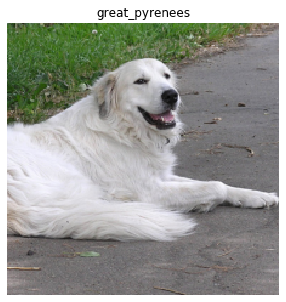

In [42]:
show_at(tls.train, 0)

An interesting thing is that unless you pass `train_setup=False`, your transforms are setup on the training set only (which is best practices): the `items` received by <code>setups</code> are just the elements of the training set. 

### Getting to `DataLoaders`

From a `TfmdLists`, getting a `DataLoaders` object is very easy, you just have to call the `dataloaders` method:

In [43]:
dls = tls.dataloaders(bs=64)

And `show_batch` will just *work*:

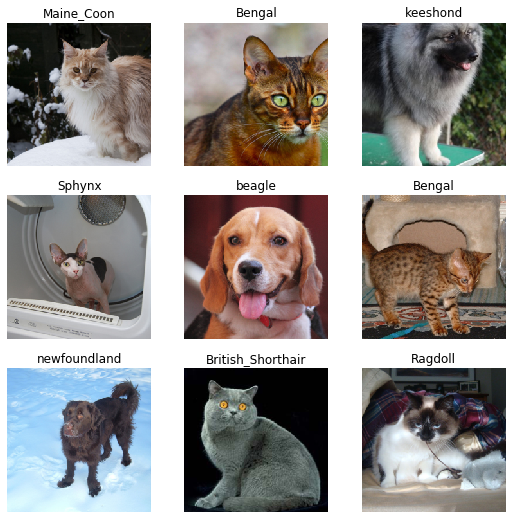

In [44]:
dls.show_batch()

You can even add augmentation transforms, since we have a proper fastai typed image. Just remember to add the `IntToFloatTensor`  transform that deals with the conversion of int to float (augmentation transforms of fastai on the GPU require float tensors). When calling `TfmdLists.dataloaders`, you pass the `batch_tfms` to `after_batch` (and potential new `item_tfms` to `after_item`):

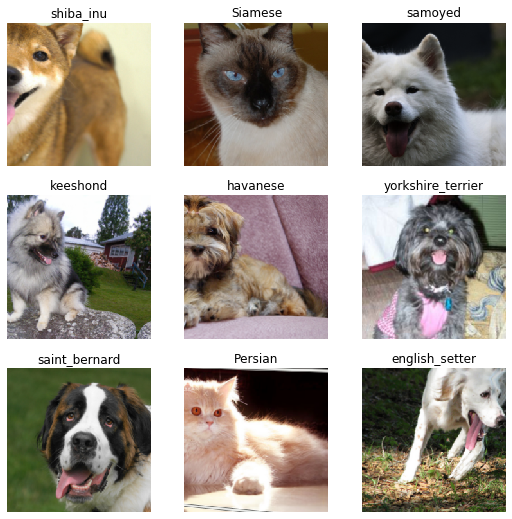

In [45]:
dls = tls.dataloaders(bs=64, after_batch=[IntToFloatTensor(), *aug_transforms()])
dls.show_batch()

### Using `Datasets`

`Datasets` applies a list of list of transforms (or list of `Pipeline`s) lazily to items of a collection, creating one output per list of transforms/`Pipeline`. This makes it easier for us to separate out steps of a process, so that we can re-use them and modify the process more easily. This is what lays the foundation of the data block API: we can easily mix and match types as inputs or outputs as they are associated to certain pipelines of transforms.

For instance, let's write our own `ImageResizer` transform with two different implementations for images or masks:

In [46]:
class ImageResizer(Transform):
    order=1
    "Resize image to `size` using `resample`"
    def __init__(self, size, resample=Image.BILINEAR):
        if not is_listy(size): size=(size,size)
        self.size,self.resample = (size[1],size[0]),resample

    def encodes(self, o:PILImage): return o.resize(size=self.size, resample=self.resample)
    def encodes(self, o:PILMask):  return o.resize(size=self.size, resample=Image.NEAREST)

Specifying the type-annotations makes it so that our transform does nothing to thigns that are neither `PILImage` or `PILMask`, and resize images with `self.resample`, masks with the nearest neighbor interpolation. To create a `Datasets`, we then pass two pipelines of transforms, one for the input and one for the target:

In [47]:
tfms = [[PILImage.create, ImageResizer(128), ToTensor(), IntToFloatTensor()],
        [labeller, Categorize()]]
dsets = Datasets(items, tfms)

We can check that inputs and outputs have the right types:

In [48]:
t = dsets[0]
type(t[0]),type(t[1])

(fastai.torch_core.TensorImage, fastai.torch_core.TensorCategory)

We can decode and show using `dsets`:

In [49]:
x,y = dsets.decode(t)
x.shape,y

(torch.Size([3, 128, 128]), 'saint_bernard')

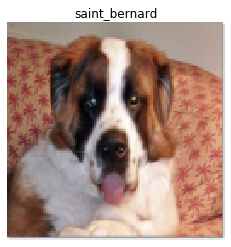

In [50]:
dsets.show(t);

And we can pass our train/validation split like in `TfmdLists`:

In [51]:
dsets = Datasets(items, tfms, splits=splits)

But we are not using the fact that `Transform`s dispatch over tuples here. `ImageResizer`, `ToTensor` and `IntToFloatTensor` could be passed as transforms over the tuple. This is done in `.dataloaders` by passing them to `after_item`. They won't do anything to the category but will only be applied to the inputs.

In [52]:
tfms = [[PILImage.create], [labeller, Categorize()]]
dsets = Datasets(items, tfms, splits=splits)
dls = dsets.dataloaders(bs=64, after_item=[ImageResizer(128), ToTensor(), IntToFloatTensor()])

And we can check it works with `show_batch`:

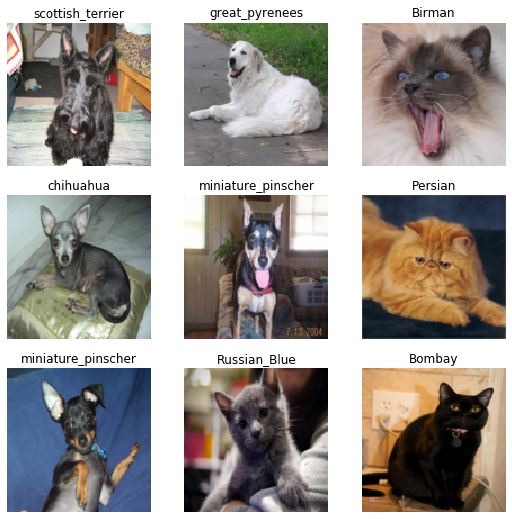

In [53]:
dls.show_batch()

If we just wanted to build one `DataLoader` from our `Datasets` (or the previous `TfmdLists`), you can pass it directly to `TfmdDL`:

In [54]:
dsets = Datasets(items, tfms)
dl = TfmdDL(dsets, bs=64, after_item=[ImageResizer(128), ToTensor(), IntToFloatTensor()])

### Segmentation

By using the same transforms in `after_item` but a different kind of targets (here segmentation masks), the targets are automatically processed as they should with the type-dispatch system.

In [55]:
cv_source = untar_data(URLs.CAMVID_TINY)
cv_items = get_image_files(cv_source/'images')
cv_splitter = RandomSplitter(seed=42)
cv_split = cv_splitter(cv_items)
cv_label = lambda o: cv_source/'labels'/f'{o.stem}_P{o.suffix}'

In [56]:
tfms = [[PILImage.create], [cv_label, PILMask.create]]
cv_dsets = Datasets(cv_items, tfms, splits=cv_split)
dls = cv_dsets.dataloaders(bs=64, after_item=[ImageResizer(128), ToTensor(), IntToFloatTensor()])

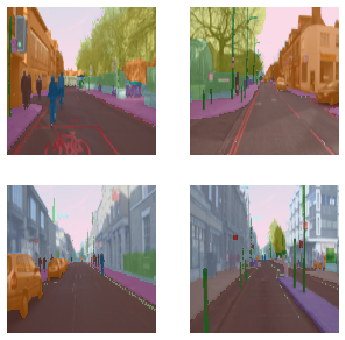

In [57]:
dls.show_batch(max_n=4)

## Adding a test dataloader for inference

Let's take back our pets dataset...

In [58]:
tfms = [[PILImage.create], [labeller, Categorize()]]
dsets = Datasets(items, tfms, splits=splits)
dls = dsets.dataloaders(bs=64, after_item=[ImageResizer(128), ToTensor(), IntToFloatTensor()])

...and imagine we have some new files to classify.

In [59]:
path = untar_data(URLs.PETS)
tst_files = get_image_files(path/"images")

In [60]:
len(tst_files)

7390

We can create a dataloader that takes those files and applies the same transforms as the validation set with `DataLoaders.test_dl`:

In [61]:
tst_dl = dls.test_dl(tst_files)

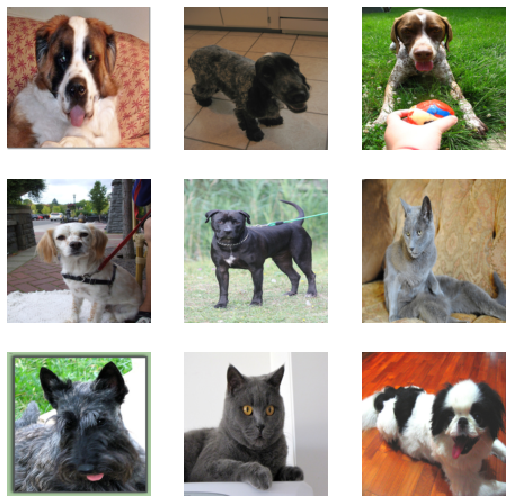

In [62]:
tst_dl.show_batch(max_n=9)

**Extra:**  
You can call `learn.get_preds` passing this newly created dataloaders to make predictions on our new images!  
What is really cool is that after you finished training your model, you can save it with `learn.export`, this is also going to save all the transforms that need to be applied to your data. In inference time you just need to load your learner with `load_learner` and you can immediately create a dataloader with `test_dl` to use it to generate new predictions!

## fin -